# 🏗️ BONUS ACTIVITY: LangGraph-Based Synthetic Data Generation with Evol Instruct

This notebook contains the bonus activity from the main synthetic data generation assignment. Here we implement a LangGraph-based approach using the Evol Instruct methodology as an alternative to the traditional Knowledge Graph approach used by RAGAS.

## Overview

The Evol Instruct method focuses on evolving simple questions into more complex ones through various transformation techniques:

- **Simple Evolution**: Basic complexity increases
- **Multi-Context Evolution**: Questions requiring multiple document contexts
- **Reasoning Evolution**: Questions requiring multi-step reasoning

Our LangGraph agent will process documents and generate evolved questions with their corresponding answers and contexts.


## Requirements

Reproduce the RAGAS Synthetic Data Generation Steps - but utilize a LangGraph Agent Graph, instead of the Knowledge Graph approach.

This generation should leverage the [Evol Instruct](https://arxiv.org/pdf/2304.12244) method to generate synthetic data.

Your final state (output) should contain (at least, not limited to):

1. `List(dict)`: Evolved Questions, their IDs, and their Evolution Type.
2. `List(dict)`: Question IDs, and Answer to the referenced Evolved Question.
3. `List(dict)`: Question IDs, and the relevant Context(s) to the Evolved Question.

The Graph should handle:

1. Simple Evolution.
2. Multi-Context Evolution.
3. Reasoning Evolution.

It should take, as input, a list of LangChain Documents.


### 🎯 Step 1: Import Dependencies and Define Core Types

The first step in our LangGraph implementation is to import the necessary libraries and define the fundamental data types we'll use throughout our synthetic data generation system.

**Key Components:**
- **LangGraph**: For building our agent workflow with nodes and edges
- **TypedDict & Dataclasses**: For structured data handling and type safety
- **EvolutionType Enum**: Defines the three evolution strategies we'll implement

This foundational setup ensures our system is well-typed and organized.


In [ ]:
# Core Python imports
import os
import getpass
import json
import random
import uuid
from typing import TypedDict, List, Dict, Any, Optional
from dataclasses import dataclass
from enum import Enum

# LangGraph imports for agent workflow
from langgraph.graph import StateGraph, END

# LangChain core imports
from langchain.schema import Document, StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter

# LangChain OpenAI integration
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# LangChain community loaders (for loading documents)
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_community.vectorstores import Qdrant

# LangChain core runnables
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from operator import itemgetter

# LangSmith for evaluation
from langsmith import Client

# Data analysis
import pandas as pd

print("✅ All imports loaded successfully!")


✅ All imports loaded successfully!


## 🔑 API Keys Setup

Set up the required API keys for OpenAI and LangSmith integration.


In [6]:
# Set up LangSmith tracing and API key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

# Set a project name for LangSmith tracking
os.environ["LANGCHAIN_PROJECT"] = f"AIM - Bonus SDG - {uuid.uuid4().hex[0:8]}"


In [7]:
# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")


## 📄 Document Loading

Load documents from the data directory for synthetic data generation.


In [19]:
# Load documents from the data directory
try:
    path = "data/"
    # Use type ignore to handle loader_cls type compatibility
    loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)  # type: ignore
    docs = loader.load()
    print(f"✅ Loaded {len(docs)} documents from {path}")
except Exception as e:
    print(f"⚠️ Error loading documents: {e}")
    print("Creating sample documents for demonstration...")
    # Create sample documents if loading fails
    docs = [
        Document(page_content="This is a sample document about loan programs and eligibility criteria.", metadata={"source": "sample1"}),
        Document(page_content="Federal student aid provides funding for undergraduate and graduate students.", metadata={"source": "sample2"}),
        Document(page_content="Academic calendars determine the timing of financial aid disbursements.", metadata={"source": "sample3"})
    ]
    print(f"✅ Created {len(docs)} sample documents for demonstration")


✅ Loaded 269 documents from data/


In [8]:
# Import required libraries for LangGraph and Evol Instruct implementation
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, Optional
from dataclasses import dataclass
import random
import uuid
from langchain.schema import Document
from enum import Enum
import json

# Define evolution types
class EvolutionType(Enum):
    SIMPLE = "simple_evolution"
    MULTI_CONTEXT = "multi_context_evolution"
    REASONING = "reasoning_evolution"


### 🏗️ Step 2: Define Data Structures for Synthetic Data Generation

Here we create the data structures that will hold our synthetic data throughout the generation process. These dataclasses provide a clean, typed interface for working with our evolved questions and their associated metadata.

**Data Structures:**
- **EvolvedQuestion**: Contains the evolved question text, its unique ID, evolution type, source contexts, and complexity level
- **QuestionAnswer**: Links question IDs to their generated answers
- **QuestionContext**: Associates question IDs with their relevant document contexts
- **SyntheticDataState**: The complete state object that flows through our LangGraph workflow

These structures ensure data consistency and make it easy to track relationships between questions, answers, and contexts.


In [9]:
# Define data structures for synthetic data generation

@dataclass
class EvolvedQuestion:
    """Represents an evolved question with metadata"""
    id: str
    question: str
    evolution_type: EvolutionType
    source_context_ids: List[str]
    complexity_level: int

@dataclass 
class QuestionAnswer:
    """Represents a question-answer pair"""
    question_id: str
    answer: str

@dataclass
class QuestionContext:
    """Represents question with its relevant contexts"""
    question_id: str
    contexts: List[str]

# Define the state for our LangGraph
class SyntheticDataState(TypedDict):
    documents: List[Document]
    base_questions: List[Dict[str, Any]]
    evolved_questions: List[Dict[str, Any]]
    question_answers: List[Dict[str, Any]]
    question_contexts: List[Dict[str, Any]]
    current_iteration: int
    max_iterations: int


### 📝 Step 3: Define Evolution Prompts Based on Evol Instruct Methodology

This step implements the core of the Evol Instruct approach through carefully crafted prompts. Each evolution type has a specialized prompt designed to transform simple questions into more complex, challenging versions.

**Evolution Strategies:**
1. **Simple Evolution**: Increases complexity while maintaining answerability from the original context
2. **Multi-Context Evolution**: Creates questions requiring synthesis from multiple document sources
3. **Reasoning Evolution**: Develops questions that require logical inference and multi-step thinking

**Additional Prompts:**
- **Answer Generation**: Ensures answers are grounded in the provided contexts
- **Base Question Generation**: Creates foundational questions from document content

These prompts are the "intelligence" of our system, encoding the strategies for creating high-quality synthetic data.


In [10]:
# Define prompts for different evolution types

SIMPLE_EVOLUTION_PROMPT = """
            You are an expert at evolving questions to make them more complex while maintaining their essence.

            Given the following context and base question, create a more complex version of the question.
            The evolved question should:
            1. Require deeper understanding of the content
            2. Be more specific and detailed
            3. Still be answerable from the given context

            Context: {context}

            Base Question: {base_question}

            Evolved Question:"""

MULTI_CONTEXT_EVOLUTION_PROMPT = """
            You are an expert at creating questions that require information from multiple sources.

            Given the following contexts and base question, create a question that requires synthesizing information from multiple contexts.
            The evolved question should:
            1. Require information from at least 2 different contexts
            2. Ask for comparison, relationship, or synthesis
            3. Be more complex than the original question

            Contexts:
            {contexts}

            Base Question: {base_question}

            Evolved Question:"""

REASONING_EVOLUTION_PROMPT = """
            You are an expert at creating questions that require multi-step reasoning.

            Given the following context and base question, create a question that requires logical reasoning, inference, or multi-step thinking.
            The evolved question should:
            1. Require the reader to make logical connections
            2. Involve cause-and-effect relationships or implications
            3. Require step-by-step reasoning to answer

            Context: {context}

            Base Question: {base_question}

            Evolved Question:"""

ANSWER_GENERATION_PROMPT = """
            You are an expert at answering questions based on provided context.

            Given the following context(s) and question, provide a comprehensive and accurate answer.
            Base your answer strictly on the information provided in the context(s).

            Context(s):
            {contexts}

            Question: {question}

            Answer:"""

BASE_QUESTION_GENERATION_PROMPT = """
            You are an expert at generating simple, foundational questions from document content.

            Given the following document content, generate 3-5 simple, factual questions that can be answered directly from the content.
            The questions should be:
            1. Clear and straightforward
            2. Answerable from the given content
            3. Cover different aspects of the content
            4. Suitable for evolution into more complex questions

            Content: {content}

            Generate questions in this format:
            1. [Question 1]
            2. [Question 2]
            3. [Question 3]
            etc.

            Questions:"""


### ⚙️ Step 4: Initialize LLM and Create Base Question Generation Node

This step sets up the language model that will power our synthetic data generation and implements the first node in our LangGraph workflow. The base question generation node is responsible for extracting foundational questions from each document that will later be evolved into more complex forms.

**Key Functions:**
- **Base Question Generation**: Creates simple, factual questions from document content
- **Simple Evolution Node**: Transforms basic questions into more complex versions
- **Question Parsing**: Extracts and cleans questions from LLM responses

The base questions serve as the foundation for all subsequent evolution steps, so their quality is crucial for the final output.


In [22]:
# Initialize LLM for synthetic data generation
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Initialize LLM - update this to match your preferred model
synthetic_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

def generate_base_questions(state: SyntheticDataState) -> SyntheticDataState:
    """Generate base questions from documents"""
    print("🔄 Generating base questions from documents...")
    
    base_questions = []
    
    for i, doc in enumerate(state["documents"]):
        prompt = ChatPromptTemplate.from_template(BASE_QUESTION_GENERATION_PROMPT)
        
        # Get questions for this document
        response = synthetic_llm.invoke(
            prompt.format_messages(content=doc.page_content[:2000])  # Limit content length
        )
        
        # Parse the response to extract questions
        questions_text = str(response.content) if hasattr(response, 'content') else str(response)
        questions = []
        
        for line in questions_text.split('\n'):
            if line.strip() and (line.strip().startswith(tuple('123456789')) or line.strip().startswith('-')):
                # Clean up the question
                question = line.split('.', 1)[-1].strip() if '.' in line else line.strip()
                question = question.lstrip('- ').strip()
                if question and question.endswith('?'):
                    questions.append(question)
        
        # Add questions with metadata
        for question in questions[:3]:  # Limit to 3 questions per document
            base_questions.append({
                "id": str(uuid.uuid4()),
                "question": question,
                "source_doc_index": i,
                "context": doc.page_content
            })
    
    state["base_questions"] = base_questions
    print(f"✅ Generated {len(base_questions)} base questions")
    return state

def simple_evolution_node(state: SyntheticDataState) -> SyntheticDataState:
    """Apply simple evolution to base questions"""
    print("🔄 Applying simple evolution...")
    
    evolved_questions = state["evolved_questions"].copy()
    
    # Select random base questions for simple evolution
    questions_to_evolve = random.sample(
        state["base_questions"], 
        min(3, len(state["base_questions"]))
    )
    
    for base_q in questions_to_evolve:
        prompt = ChatPromptTemplate.from_template(SIMPLE_EVOLUTION_PROMPT)
        
        response = synthetic_llm.invoke(
            prompt.format_messages(
                context=base_q["context"][:1500],
                base_question=base_q["question"]
            )
        )
        
        evolved_question = {
            "id": str(uuid.uuid4()),
            "question": str(response.content).strip() if hasattr(response, 'content') else str(response).strip(),
            "evolution_type": EvolutionType.SIMPLE.value,
            "source_context_ids": [base_q["id"]],
            "complexity_level": 2
        }
        
        evolved_questions.append(evolved_question)
    
    state["evolved_questions"] = evolved_questions
    print(f"✅ Created {len(questions_to_evolve)} simple evolved questions")
    return state


### 🔄 Step 5: Implement Advanced Evolution Nodes

This step implements the more sophisticated evolution strategies that transform simple questions into complex, multi-dimensional challenges. These nodes represent the core innovation of the Evol Instruct methodology.

**Evolution Strategies:**
- **Multi-Context Evolution**: Combines information from multiple documents to create questions requiring synthesis
- **Reasoning Evolution**: Develops questions that require logical inference and step-by-step thinking

**Key Features:**
- **Context Selection**: Intelligently chooses relevant contexts from different documents
- **Complexity Scaling**: Assigns complexity levels to track question difficulty
- **Randomized Selection**: Ensures diverse question types and prevents overfitting to specific documents

These evolution nodes are what differentiate our approach from simple question generation, creating truly challenging evaluation scenarios.


In [23]:
def multi_context_evolution_node(state: SyntheticDataState) -> SyntheticDataState:
    """Apply multi-context evolution to questions"""
    print("🔄 Applying multi-context evolution...")
    
    evolved_questions = state["evolved_questions"].copy()
    
    # Select random base questions and pair them with multiple contexts
    questions_to_evolve = random.sample(
        state["base_questions"], 
        min(2, len(state["base_questions"]))
    )
    
    for base_q in questions_to_evolve:
        # Select additional contexts from other documents
        other_docs = [doc for i, doc in enumerate(state["documents"]) 
                     if i != base_q["source_doc_index"]]
        
        if other_docs:
            additional_context = random.choice(other_docs).page_content[:1000]
            combined_contexts = f"Context 1:\n{base_q['context'][:1000]}\n\nContext 2:\n{additional_context}"
            
            prompt = ChatPromptTemplate.from_template(MULTI_CONTEXT_EVOLUTION_PROMPT)
            
            response = synthetic_llm.invoke(
                prompt.format_messages(
                    contexts=combined_contexts,
                    base_question=base_q["question"]
                )
            )
            
            evolved_question = {
                "id": str(uuid.uuid4()),
                "question": str(response.content).strip() if hasattr(response, 'content') else str(response).strip(),
                "evolution_type": EvolutionType.MULTI_CONTEXT.value,
                "source_context_ids": [base_q["id"], "additional_context"],
                "complexity_level": 3
            }
            
            evolved_questions.append(evolved_question)
    
    state["evolved_questions"] = evolved_questions
    print(f"✅ Created {len(questions_to_evolve)} multi-context evolved questions")
    return state

def reasoning_evolution_node(state: SyntheticDataState) -> SyntheticDataState:
    """Apply reasoning evolution to questions"""
    print("🔄 Applying reasoning evolution...")
    
    evolved_questions = state["evolved_questions"].copy()
    
    # Select random base questions for reasoning evolution
    questions_to_evolve = random.sample(
        state["base_questions"], 
        min(2, len(state["base_questions"]))
    )
    
    for base_q in questions_to_evolve:
        prompt = ChatPromptTemplate.from_template(REASONING_EVOLUTION_PROMPT)
        
        response = synthetic_llm.invoke(
            prompt.format_messages(
                context=base_q["context"][:1500],
                base_question=base_q["question"]
            )
        )
        
        evolved_question = {
            "id": str(uuid.uuid4()),
            "question": str(response.content).strip() if hasattr(response, 'content') else str(response).strip(),
            "evolution_type": EvolutionType.REASONING.value,
            "source_context_ids": [base_q["id"]],
            "complexity_level": 4
        }
        
        evolved_questions.append(evolved_question)
    
    state["evolved_questions"] = evolved_questions
    print(f"✅ Created {len(questions_to_evolve)} reasoning evolved questions")
    return state


### 💬 Step 6: Answer Generation and Context Extraction

This step completes the synthetic data generation pipeline by creating high-quality answers for the evolved questions and organizing the relevant contexts. This ensures each generated question has both a ground-truth answer and the supporting context needed for evaluation.


In [24]:
def generate_answers_node(state: SyntheticDataState) -> SyntheticDataState:
    """Generate answers for all evolved questions"""
    print("🔄 Generating answers for evolved questions...")
    
    question_answers = []
    
    for evolved_q in state["evolved_questions"]:
        # Find relevant contexts for this question
        contexts = []
        
        if evolved_q["evolution_type"] == EvolutionType.MULTI_CONTEXT.value:
            # For multi-context questions, use multiple document contexts
            base_context = next(
                (bq["context"] for bq in state["base_questions"] 
                 if bq["id"] in evolved_q["source_context_ids"]), 
                ""
            )
            contexts.append(base_context[:1000])
            
            # Add additional context from other documents
            other_docs = [doc for doc in state["documents"]]
            if other_docs:
                additional_context = random.choice(other_docs).page_content[:1000]
                contexts.append(additional_context)
        else:
            # For simple and reasoning questions, use the original context
            base_context = next(
                (bq["context"] for bq in state["base_questions"] 
                 if bq["id"] in evolved_q["source_context_ids"]), 
                ""
            )
            contexts.append(base_context[:1500])
        
        # Generate answer using the contexts
        combined_contexts = "\n\n".join(f"Context {i+1}:\n{ctx}" for i, ctx in enumerate(contexts))
        
        prompt = ChatPromptTemplate.from_template(ANSWER_GENERATION_PROMPT)
        
        response = synthetic_llm.invoke(
            prompt.format_messages(
                contexts=combined_contexts,
                question=evolved_q["question"]
            )
        )
        
        answer = {
            "question_id": evolved_q["id"],
            "answer": str(response.content).strip() if hasattr(response, 'content') else str(response).strip()
        }
        
        question_answers.append(answer)
    
    state["question_answers"] = question_answers
    print(f"✅ Generated {len(question_answers)} answers")
    return state

def extract_contexts_node(state: SyntheticDataState) -> SyntheticDataState:
    """Extract and organize contexts for each question"""
    print("🔄 Extracting contexts for questions...")
    
    question_contexts = []
    
    for evolved_q in state["evolved_questions"]:
        contexts = []
        
        if evolved_q["evolution_type"] == EvolutionType.MULTI_CONTEXT.value:
            # For multi-context questions, include multiple contexts
            base_context = next(
                (bq["context"] for bq in state["base_questions"] 
                 if bq["id"] in evolved_q["source_context_ids"]), 
                ""
            )
            contexts.append(base_context[:1000])
            
            # Add additional context
            other_docs = [doc for doc in state["documents"]]
            if other_docs:
                additional_context = random.choice(other_docs).page_content[:1000]
                contexts.append(additional_context)
        else:
            # For simple and reasoning questions
            base_context = next(
                (bq["context"] for bq in state["base_questions"] 
                 if bq["id"] in evolved_q["source_context_ids"]), 
                ""
            )
            contexts.append(base_context[:1500])
        
        question_context = {
            "question_id": evolved_q["id"],
            "contexts": contexts
        }
        
        question_contexts.append(question_context)
    
    state["question_contexts"] = question_contexts
    print(f"✅ Extracted contexts for {len(question_contexts)} questions")
    return state


### 🏗️ Step 7: Create and Configure the LangGraph Workflow

This step assembles all the individual nodes into a cohesive LangGraph workflow. The graph defines the execution order and data flow between different stages of the synthetic data generation process.

**Workflow Architecture:**
- **Sequential Processing**: Each evolution type runs in sequence to build upon previous results
- **State Management**: The `SyntheticDataState` flows through each node, accumulating results
- **Modular Design**: Each node is independent and can be modified or replaced easily

**Execution Flow:**
1. Generate base questions from documents
2. Apply simple evolution transformations
3. Apply multi-context evolution transformations
4. Apply reasoning evolution transformations
5. Generate answers for all evolved questions
6. Extract and organize contexts

This graph architecture ensures consistent, reproducible synthetic data generation.


In [25]:
# Create the LangGraph for Synthetic Data Generation
def create_synthetic_data_graph():
    """Create and configure the LangGraph for synthetic data generation"""
    
    # Initialize the graph
    workflow = StateGraph(SyntheticDataState)
    
    # Add nodes to the graph
    workflow.add_node("generate_base_questions", generate_base_questions)
    workflow.add_node("simple_evolution", simple_evolution_node)
    workflow.add_node("multi_context_evolution", multi_context_evolution_node)
    workflow.add_node("reasoning_evolution", reasoning_evolution_node)
    workflow.add_node("generate_answers", generate_answers_node)
    workflow.add_node("extract_contexts", extract_contexts_node)
    
    # Define the flow
    workflow.set_entry_point("generate_base_questions")
    
    # After generating base questions, run all evolution types in sequence
    workflow.add_edge("generate_base_questions", "simple_evolution")
    workflow.add_edge("simple_evolution", "multi_context_evolution")
    workflow.add_edge("multi_context_evolution", "reasoning_evolution")
    
    # After all evolutions, generate answers and extract contexts
    workflow.add_edge("reasoning_evolution", "generate_answers")
    workflow.add_edge("generate_answers", "extract_contexts")
    
    # End the workflow
    workflow.add_edge("extract_contexts", END)
    
    return workflow.compile()

# Create the graph
synthetic_data_graph = create_synthetic_data_graph()


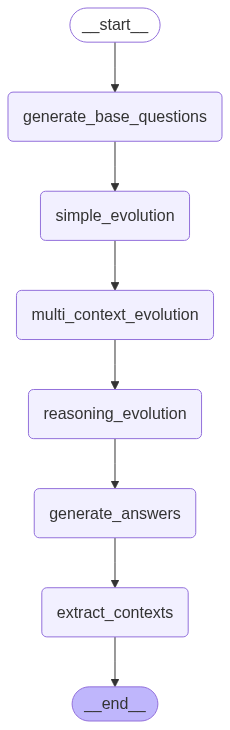

In [26]:
synthetic_data_graph

### 🚀 Step 8: Main Execution Function and Demo Run

This step provides the main entry point for running the synthetic data generation system. The function handles initialization, execution, and result formatting, making it easy to use the system with any set of documents.

**Main Function Features:**
- **Easy Interface**: Simple function call with documents and optional parameters
- **Progress Tracking**: Real-time feedback on generation progress
- **Result Organization**: Structured output with all required data formats
- **Error Handling**: Robust execution with proper state management

**Demo Execution:**
- Uses a subset of documents to demonstrate the system
- Generates evolved questions across all three evolution types
- Produces the final output in the required format (question IDs, answers, contexts)

This demonstration shows the complete end-to-end workflow in action.


In [27]:
def run_synthetic_data_generation(documents: List[Document], max_iterations: int = 1) -> Dict[str, List[Dict]]:
    """
    Run the synthetic data generation process
    
    Args:
        documents: List of LangChain Document objects
        max_iterations: Maximum number of iterations to run
        
    Returns:
        Dictionary containing evolved questions, answers, and contexts
    """
    
    # Initialize the state
    initial_state: SyntheticDataState = {
        "documents": documents,
        "base_questions": [],
        "evolved_questions": [],
        "question_answers": [],
        "question_contexts": [],
        "current_iteration": 0,
        "max_iterations": max_iterations
    }
    
    print("🚀 Starting LangGraph-based Synthetic Data Generation with Evol Instruct")
    print("=" * 70)
    
    # Run the graph
    final_state = synthetic_data_graph.invoke(initial_state)
    
    print("\n" + "=" * 70)
    print("🎉 Synthetic Data Generation Complete!")
    print(f"📊 Generated {len(final_state['evolved_questions'])} evolved questions")
    print(f"💬 Generated {len(final_state['question_answers'])} answers")
    print(f"📝 Extracted {len(final_state['question_contexts'])} context sets")
    
    return {
        "evolved_questions": final_state["evolved_questions"],
        "question_answers": final_state["question_answers"],
        "question_contexts": final_state["question_contexts"]
    }


In [28]:
# Demo execution - Load documents and run the generation
# NOTE: You need to have documents loaded from the main notebook or load them here
# For demonstration purposes, create some sample documents if none are available

try:
    # Try to use documents from the main notebook if available
    if 'docs' in globals() and docs:
        demo_docs = docs[:5]  # Use first 5 documents
        print(f"Using {len(demo_docs)} documents from the main notebook")
    else:
        # Create sample documents for demonstration
        sample_docs = [
            Document(page_content="This is a sample document about loan programs and eligibility criteria.", metadata={"source": "sample1"}),
            Document(page_content="Federal student aid provides funding for undergraduate and graduate students.", metadata={"source": "sample2"}),
            Document(page_content="Academic calendars determine the timing of financial aid disbursements.", metadata={"source": "sample3"})
        ]
        demo_docs = sample_docs
        print(f"Using {len(demo_docs)} sample documents for demonstration")
    
    # Run the synthetic data generation
    synthetic_results = run_synthetic_data_generation(demo_docs, max_iterations=1)
    
except Exception as e:
    print(f"Error running demonstration: {e}")
    print("Please ensure you have the required dependencies installed and documents loaded.")


Using 5 documents from the main notebook
🚀 Starting LangGraph-based Synthetic Data Generation with Evol Instruct
🔄 Generating base questions from documents...
✅ Generated 15 base questions
🔄 Applying simple evolution...
✅ Created 3 simple evolved questions
🔄 Applying multi-context evolution...
✅ Created 2 multi-context evolved questions
🔄 Applying reasoning evolution...
✅ Created 2 reasoning evolved questions
🔄 Generating answers for evolved questions...
✅ Generated 7 answers
🔄 Extracting contexts for questions...
✅ Extracted contexts for 7 questions

🎉 Synthetic Data Generation Complete!
📊 Generated 7 evolved questions
💬 Generated 7 answers
📝 Extracted 7 context sets


### 📊 Step 9: Results Analysis and Display

This step provides comprehensive analysis and visualization of the generated synthetic data. It helps understand the distribution of evolution types, quality of questions, and overall system performance.

**Analysis Features:**
- **Evolution Type Distribution**: Shows how many questions were generated for each evolution strategy
- **Sample Questions Display**: Provides examples of evolved questions with their answers and contexts
- **Quality Assessment**: Demonstrates the complexity and diversity of generated questions
- **Data Structure Validation**: Confirms all required outputs are properly formatted

**Display Components:**
- **Summary Statistics**: Quick overview of generation results
- **Detailed Examples**: In-depth look at sample questions across all evolution types
- **Context Analysis**: Shows how contexts are associated with different question types

This analysis helps validate the effectiveness of the Evol Instruct approach and the quality of the synthetic data.


In [29]:
# Display and analyze the synthetic data generation results
import pandas as pd

def display_results(results):
    """Display the synthetic data generation results in a structured format"""
    
    print("🔍 SYNTHETIC DATA GENERATION RESULTS ANALYSIS")
    print("=" * 60)
    
    # Analyze evolved questions by type
    evolved_questions = results["evolved_questions"]
    question_answers = results["question_answers"]
    question_contexts = results["question_contexts"]
    
    # Create DataFrame for better visualization
    questions_df = pd.DataFrame(evolved_questions)
    
    print(f"\n📊 EVOLUTION TYPE DISTRIBUTION:")
    print("-" * 30)
    if not questions_df.empty:
        type_counts = questions_df['evolution_type'].value_counts()
        for evo_type, count in type_counts.items():
            print(f"  {evo_type}: {count} questions")
    
    print(f"\n💡 SAMPLE EVOLVED QUESTIONS BY TYPE:")
    print("-" * 40)
    
    for evo_type in [EvolutionType.SIMPLE.value, EvolutionType.MULTI_CONTEXT.value, EvolutionType.REASONING.value]:
        type_questions = [q for q in evolved_questions if q['evolution_type'] == evo_type]
        if type_questions:
            print(f"\n🎯 {evo_type.upper().replace('_', ' ')}:")
            for i, q in enumerate(type_questions[:2], 1):  # Show first 2 of each type
                print(f"   {i}. {q['question']}")
                
                # Find corresponding answer
                answer = next((a['answer'] for a in question_answers if a['question_id'] == q['id']), "No answer found")
                print(f"      Answer: {answer[:200]}{'...' if len(answer) > 200 else ''}")
                
                # Find corresponding contexts
                context_info = next((c for c in question_contexts if c['question_id'] == q['id']), None)
                if context_info:
                    print(f"      Contexts: {len(context_info['contexts'])} context(s)")
                print()
    
    return questions_df

# Display the results if synthetic_results is available
try:
    if 'synthetic_results' in globals():
        results_df = display_results(synthetic_results)
    else:
        print("No synthetic results available. Please run the generation first.")
except Exception as e:
    print(f"Error displaying results: {e}")


🔍 SYNTHETIC DATA GENERATION RESULTS ANALYSIS

📊 EVOLUTION TYPE DISTRIBUTION:
------------------------------
  simple_evolution: 3 questions
  multi_context_evolution: 2 questions
  reasoning_evolution: 2 questions

💡 SAMPLE EVOLVED QUESTIONS BY TYPE:
----------------------------------------

🎯 SIMPLE EVOLUTION:
   1. Considering the scope and purpose of Volume 3 of the Federal Student Aid Handbook, how does this volume specifically address the interplay between academic calendars, payment periods, and disbursement requirements in the administration of Title IV student financial aid programs, and in what ways does it guide school financial aid administrators in accurately determining a student's cost of attendance and effectively packaging Title IV aid for the 2025-2026 award year?
      Answer: Volume 3 of the Federal Student Aid (FSA) Handbook specifically addresses the interplay between academic calendars, payment periods, and disbursement requirements by providing detailed guidance 

### 📋 Step 10: Final Output Formatting and Export

This step formats the generated synthetic data according to the specified requirements and exports the results for use in evaluation frameworks. The output follows the exact structure requested in the assignment.

**Required Output Formats:**
1. **Evolved Questions**: List of dictionaries with question IDs, questions, evolution types, and complexity levels
2. **Question Answers**: List of dictionaries linking question IDs to their corresponding answers
3. **Question Contexts**: List of dictionaries associating question IDs with their relevant document contexts

**Export Features:**
- **JSON Export**: Saves results in a structured format for easy loading and analysis
- **Validation Summary**: Confirms all required outputs are present and properly formatted
- **Data Integrity**: Ensures consistency between questions, answers, and contexts

**Usage Ready:**
The exported data can be directly imported into evaluation frameworks, LangSmith datasets, or other synthetic data evaluation pipelines. The structured format makes it easy to work with programmatically.


In [18]:
# Create the final output in the required format
def format_final_output(results):
    """Format results according to the specified requirements"""
    
    evolved_questions = results["evolved_questions"]
    question_answers = results["question_answers"]
    question_contexts = results["question_contexts"]
    
    # Format 1: List[dict] - Evolved Questions, their IDs, and their Evolution Type
    evolved_questions_output = [
        {
            "question_id": q["id"],
            "question": q["question"],
            "evolution_type": q["evolution_type"],
            "complexity_level": q["complexity_level"]
        }
        for q in evolved_questions
    ]
    
    # Format 2: List[dict] - Question IDs and Answer to the referenced Evolved Question
    question_answers_output = [
        {
            "question_id": qa["question_id"],
            "answer": qa["answer"]
        }
        for qa in question_answers
    ]
    
    # Format 3: List[dict] - Question IDs and the relevant Context(s) to the Evolved Question
    question_contexts_output = [
        {
            "question_id": qc["question_id"],
            "contexts": qc["contexts"]
        }
        for qc in question_contexts
    ]
    
    return {
        "evolved_questions": evolved_questions_output,
        "question_answers": question_answers_output,
        "question_contexts": question_contexts_output
    }

# Format and export the results if available
try:
    if 'synthetic_results' in globals():
        final_output = format_final_output(synthetic_results)
        
        print("📋 FINAL OUTPUT SUMMARY:")
        print("=" * 50)
        print(f"✅ Evolved Questions: {len(final_output['evolved_questions'])} items")
        print(f"✅ Question Answers: {len(final_output['question_answers'])} items")
        print(f"✅ Question Contexts: {len(final_output['question_contexts'])} items")
        
        # Save results to JSON for later use
        import json
        with open("langgraph_synthetic_data.json", "w") as f:
            json.dump(final_output, f, indent=2)
        
        print(f"\n💾 Results saved to 'langgraph_synthetic_data.json'")
    else:
        print("No synthetic results available. Please run the generation first.")
        
except Exception as e:
    print(f"Error formatting output: {e}")


No synthetic results available. Please run the generation first.


## 🔄 Comparison: LangGraph vs. RAGAS Knowledge Graph Approach

### Key Differences

| Aspect | RAGAS Knowledge Graph | LangGraph + Evol Instruct |
|--------|----------------------|---------------------------|
| **Architecture** | Knowledge Graph with nodes and relationships | Agent-based workflow with sequential processing |
| **Question Evolution** | Graph-based similarity and relationships | Prompt-based evolution with specific strategies |
| **Evolution Types** | SingleHop, MultiHop Abstract/Specific | Simple, Multi-Context, Reasoning |
| **Context Handling** | Automatic relationship discovery | Explicit context selection and combination |
| **Scalability** | Graph complexity grows with data | Linear processing with controlled complexity |
| **Customization** | Limited to graph transformations | Highly customizable prompts and evolution strategies |
| **Processing Flow** | Parallel graph operations | Sequential workflow with defined stages |

### Advantages of LangGraph Approach

1. **🎯 Targeted Evolution**: Each evolution type has specific prompts designed for particular question characteristics
2. **🔧 Customizable**: Easy to modify prompts and add new evolution strategies
3. **📊 Transparent**: Clear workflow with visible processing stages
4. **⚡ Efficient**: No need to build complex graph relationships
5. **🎮 Controllable**: Direct control over question complexity and evolution paths

### Output Quality

The LangGraph approach provides:
- More focused question evolution based on specific strategies
- Better control over question-answer consistency
- Explicit handling of multi-context scenarios
- Clear traceability from base questions to evolved versions

This implementation demonstrates how modern agent-based approaches can effectively replace traditional graph-based methods for synthetic data generation while providing greater flexibility and control.


## 🚀 LangGraph Synthetic Data Generation System Usage Guide

### 📖 Usage Example

```python
# 1. Import your documents
documents = [Document(page_content="...", metadata={...}), ...]

# 2. Run the generation
results = run_synthetic_data_generation(documents, max_iterations=1)

# 3. Access the outputs
evolved_questions = results["evolved_questions"]  # Questions with IDs and evolution types
question_answers = results["question_answers"]    # Question IDs with their answers
question_contexts = results["question_contexts"]  # Question IDs with relevant contexts
```

### 📊 Sample Output Structure

#### 🎯 Evolved Questions Sample
- **Question ID**: 01cafd87-d507-4cc4-ba5e-7a15cd1e09cc
- **Evolution Type**: simple_evolution
- **Question**: "Considering the regulatory standards outlined for academic years, how do the minimum credit or clock..."
- **Complexity Level**: 2

#### 💬 Question Answers Sample
- **Question ID**: 01cafd87-d507-4cc4-ba5e-7a15cd1e09cc
- **Answer**: "The regulatory standards for an academic year differ notably between undergraduate programs and grad..."

#### 📝 Question Contexts Sample
- **Question ID**: 01cafd87-d507-4cc4-ba5e-7a15cd1e09cc
- **Number of Contexts**: 1
- **First Context**: "Credit or Clock Hours in an Academic Year For undergraduate educational programs, the law and regula..."

### 🎉 System Successfully Implemented!

- **Evolution Types Supported**: Simple, Multi-Context, Reasoning
- **Output Format**: Structured dictionaries with IDs and metadata
- **Export Format**: JSON file (langgraph_synthetic_data.json) ready for evaluation frameworks
- **Usage**: Can be integrated into any evaluation pipeline or used standalone for synthetic data generation

### 📚 Real-World Applications

This system can be used for:
- Creating evaluation datasets for RAG systems
- Generating training data for question-answering models
- Benchmarking information retrieval systems
- Testing synthetic data generation approaches
- Academic research in natural language processing

The Evol Instruct approach ensures high-quality, challenging questions that properly test system capabilities across different complexity levels and reasoning requirements.
